In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
root = '/content/drive/MyDrive/Colab_Notebooks/GTSRB'
os.chdir(Root)

In [8]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [9]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed (42)

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [10]:
data_dir = '/content/drive/MyDrive/Colab_Notebooks/GTSRB'
train_path = 'Train'
test_path = 'Test'

IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [11]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [12]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

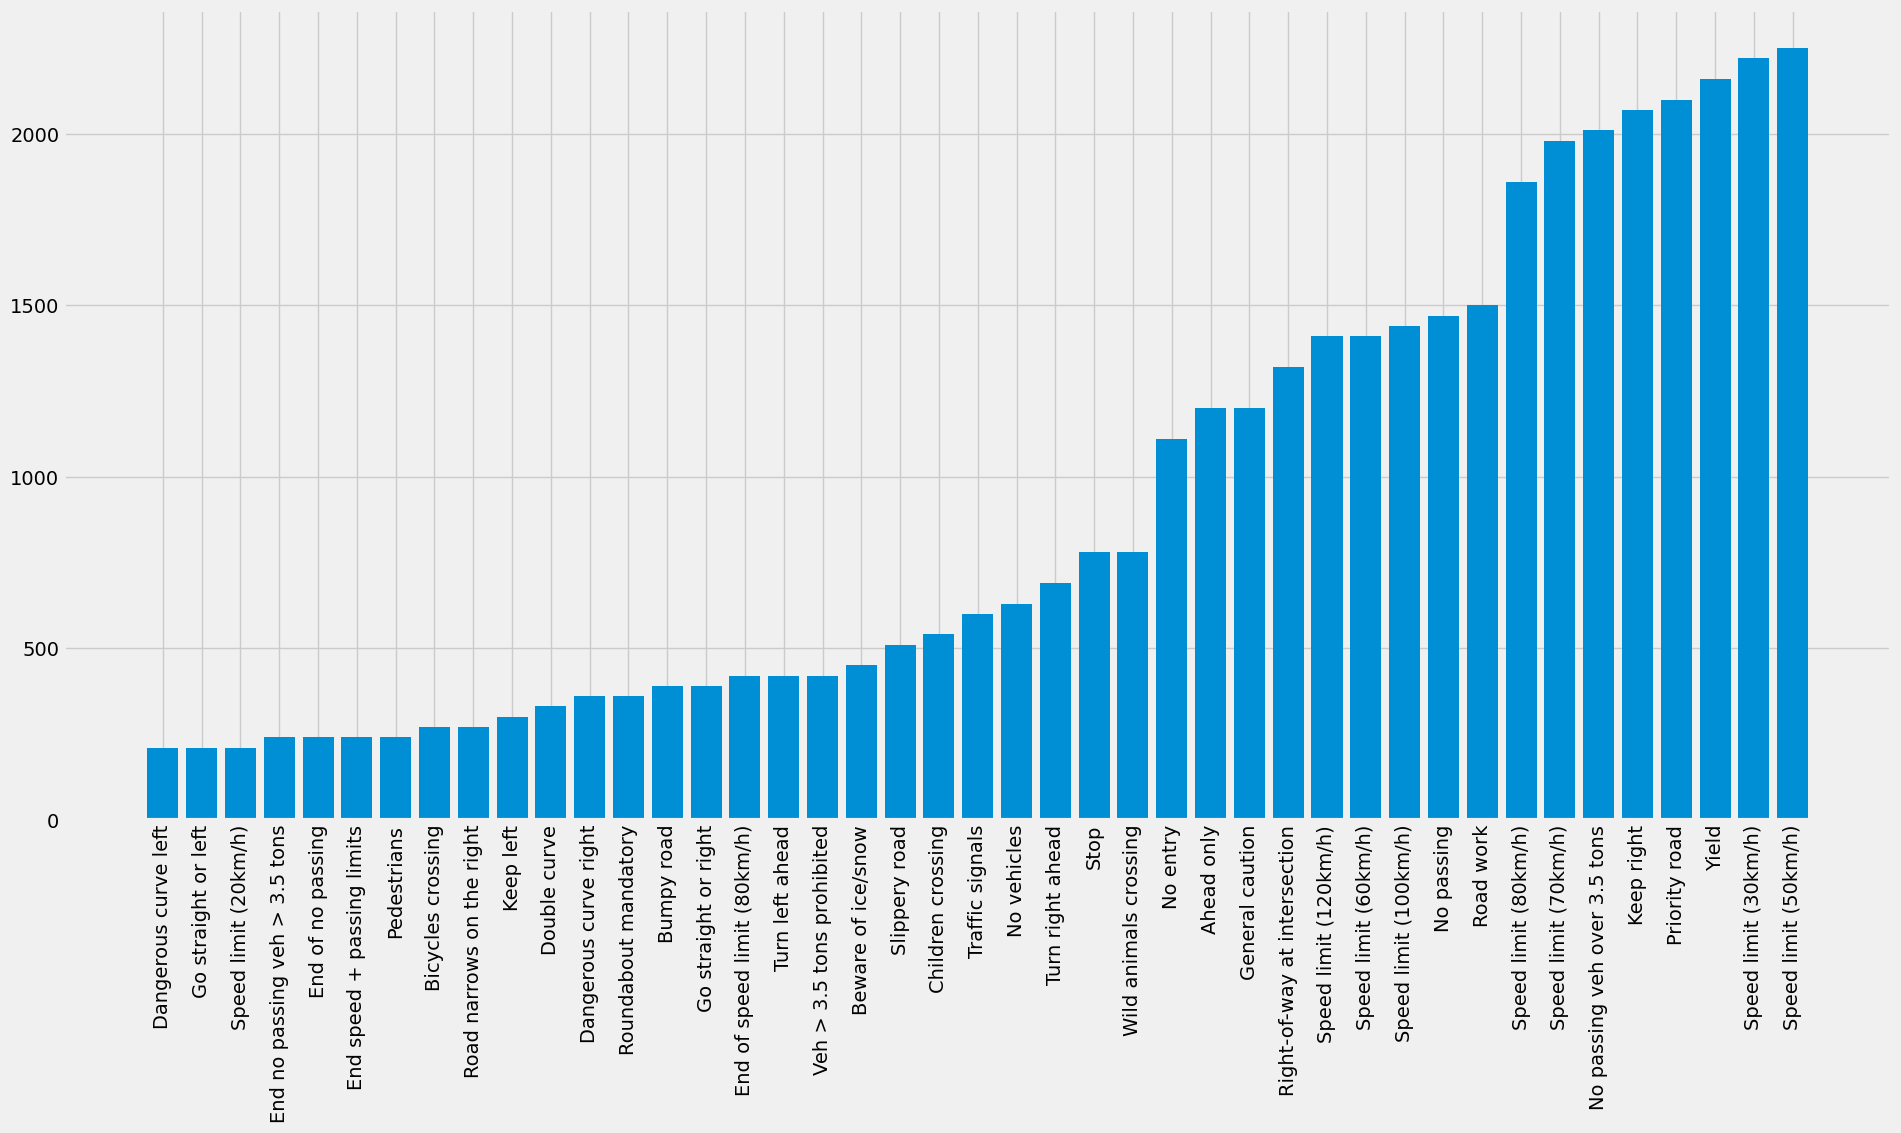

In [13]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

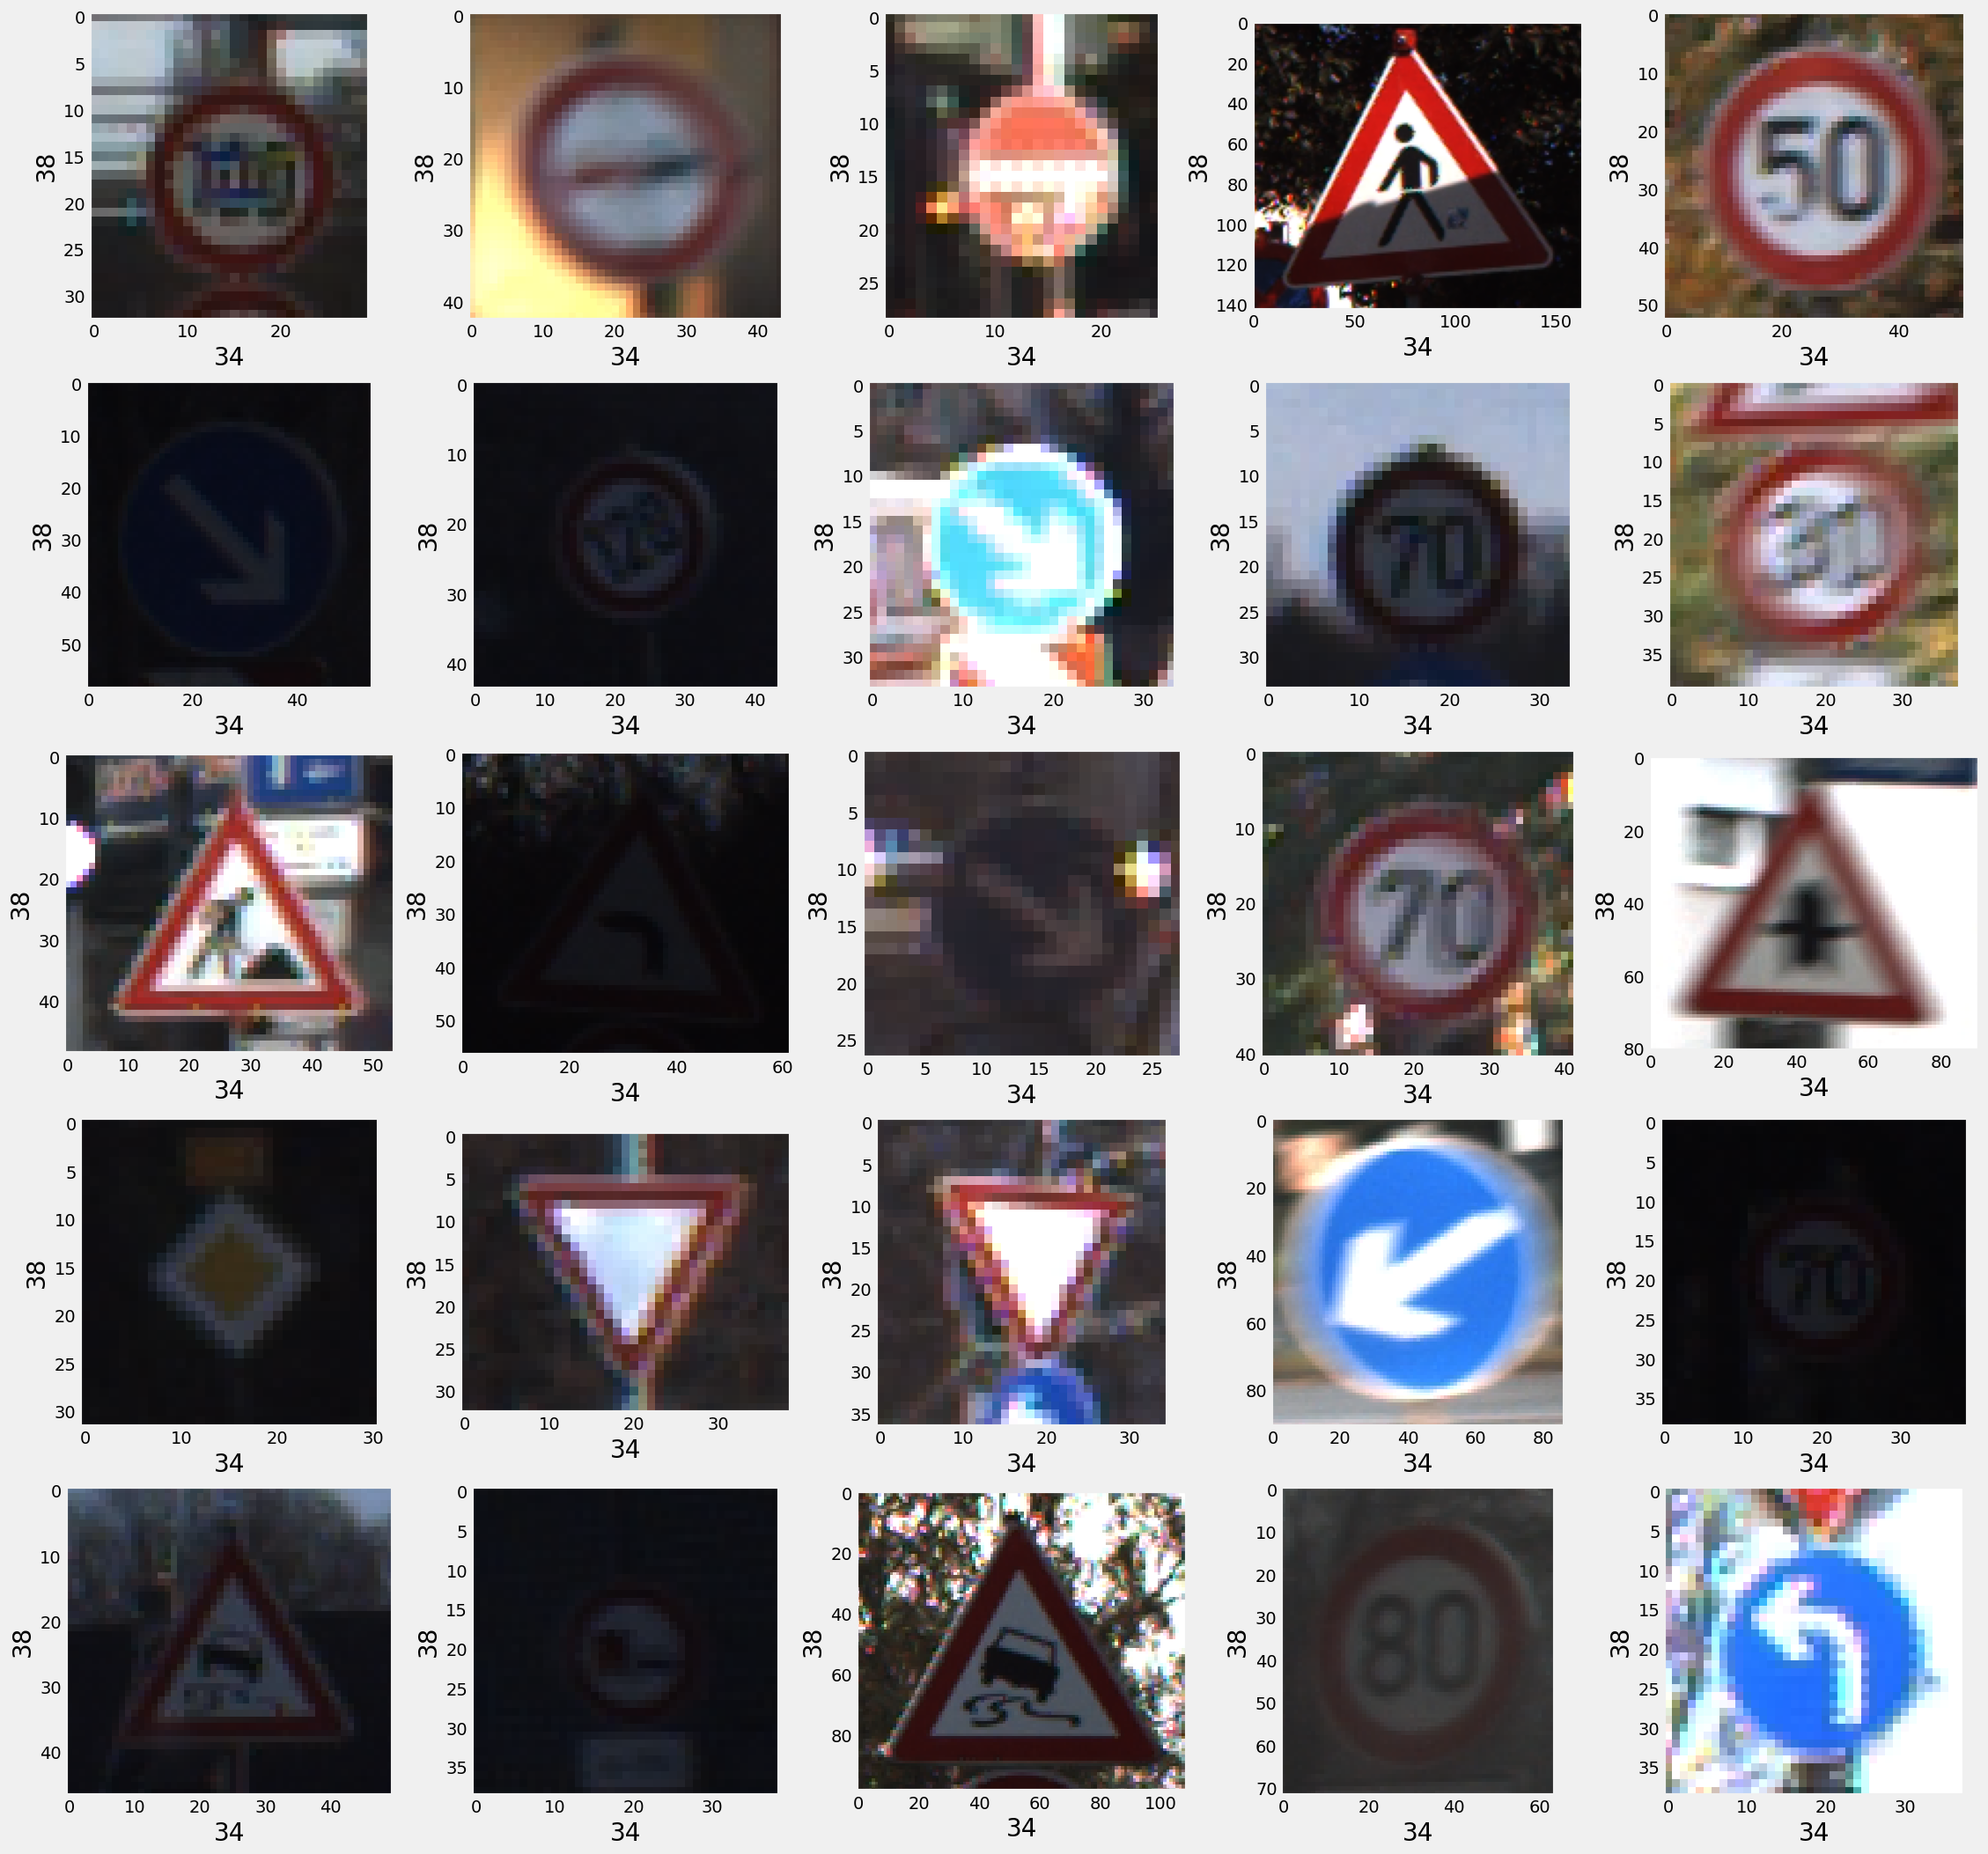

In [18]:
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    random_img = imread(random_img_path)
    plt.imshow(random_img)
    plt.grid(False)
    plt.xlabel(rand_img.shape[1], fontsize=20)
    plt.ylabel(rand_img.shape[0], fontsize=20)

## Collecting the Training Data

In [19]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

/tmp/ipython-input-3326363787.py:11: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')


(39210, 30, 30, 3) (39210,)


## Shuffling the Training Data

In [20]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the Data into Train and Validation Set

In [21]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27447, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27447,)
y_valid.shape (11763,)


## One Hot Encoding the Labels

In [22]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27447, 43)
(11763, 43)


## Making the Model

In [23]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr)
model.compile(
loss='categorical_crossentropy',
optimizer=opt,
metrics=['accuracy']
)

## Augmenting the Data and Training the Model

In [26]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 115s 127ms/step - accuracy: 0.5179 - loss: 1.9575 - val_accuracy: 0.9648 - val_loss: 0.1114
Epoch 2/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 104s 121ms/step - accuracy: 0.9382 - loss: 0.2031 - val_accuracy: 0.9836 - val_loss: 0.0572
Epoch 3/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 98s 114ms/step - accuracy: 0.9637 - loss: 0.1211 - val_accuracy: 0.9949 - val_loss: 0.0176
Epoch 4/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 99s 115ms/step - accuracy: 0.9741 - loss: 0.0862 - val_accuracy: 0.9946 - val_loss: 0.0170
Epoch 5/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 98s 114ms/step - accuracy: 0.9815 - loss: 0.0628 - val_accuracy: 0.9861 - val_loss: 0.0499
Epoch 6/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 98s 115ms/step - accuracy: 0.9765 - loss: 0.0795 - val_accuracy: 0.9904 - val_loss: 0.0295
Epoch 7/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 100s 116ms/step - accuracy: 0.9804 - loss: 0.0640 - val_accuracy: 0.9885 - val_loss: 0.0340
Epoch 8/30
858/858 ━━━━━━━━━━━━━━━━━━━━ 100s 116ms/step - accuracy: 0.9845 - loss: 0.0500 -

In [28]:
model.save('model.keras')

In [31]:
model.save_weights(
"/content/drive/MyDrive/Colab_Notebooks/GTSRB/model.weights.h5"
)

In [32]:
dir(aug)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_api_export_path',
 '_api_export_symbol_id',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize'

## Evaluating the Model

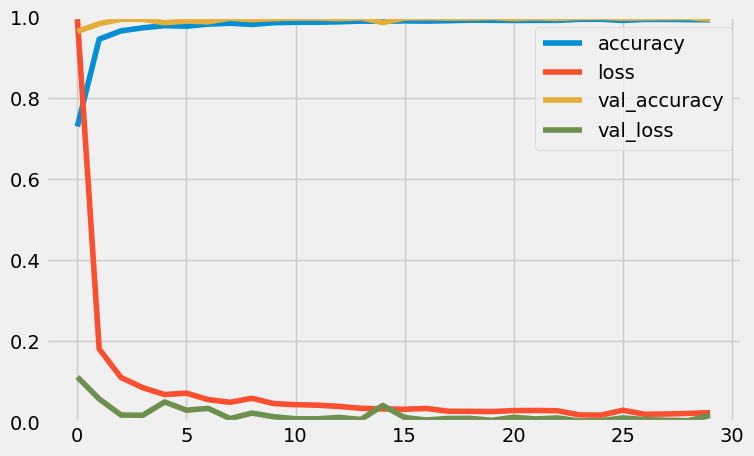

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

##  Loading the Test Data and Running the Predictions

In [49]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import os

print(os.path.exists("/content/drive/MyDrive/Colab_Notebooks/GTSRB"))
print(os.listdir("/content/drive/MyDrive/Colab_Notebooks/GTSRB"))

True
['Meta.csv', 'Test.csv', 'Train.csv', 'Meta', 'train', 'Train', 'test', 'meta', 'Test', 'model.h5', 'model.keras', 'model.weights.h5']


In [52]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred_prob = model.predict(X_test, batch_size=64, verbose=1)
pred = np.argmax(pred_prob, axis=1)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

/tmp/ipython-input-1510594179.py:11: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  image_fromarray = Image.fromarray(image, 'RGB')


198/198 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step
Test Data accuracy:  97.93349168646081


## Visualizing the Confusion Matrix

In [53]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<Axes: >

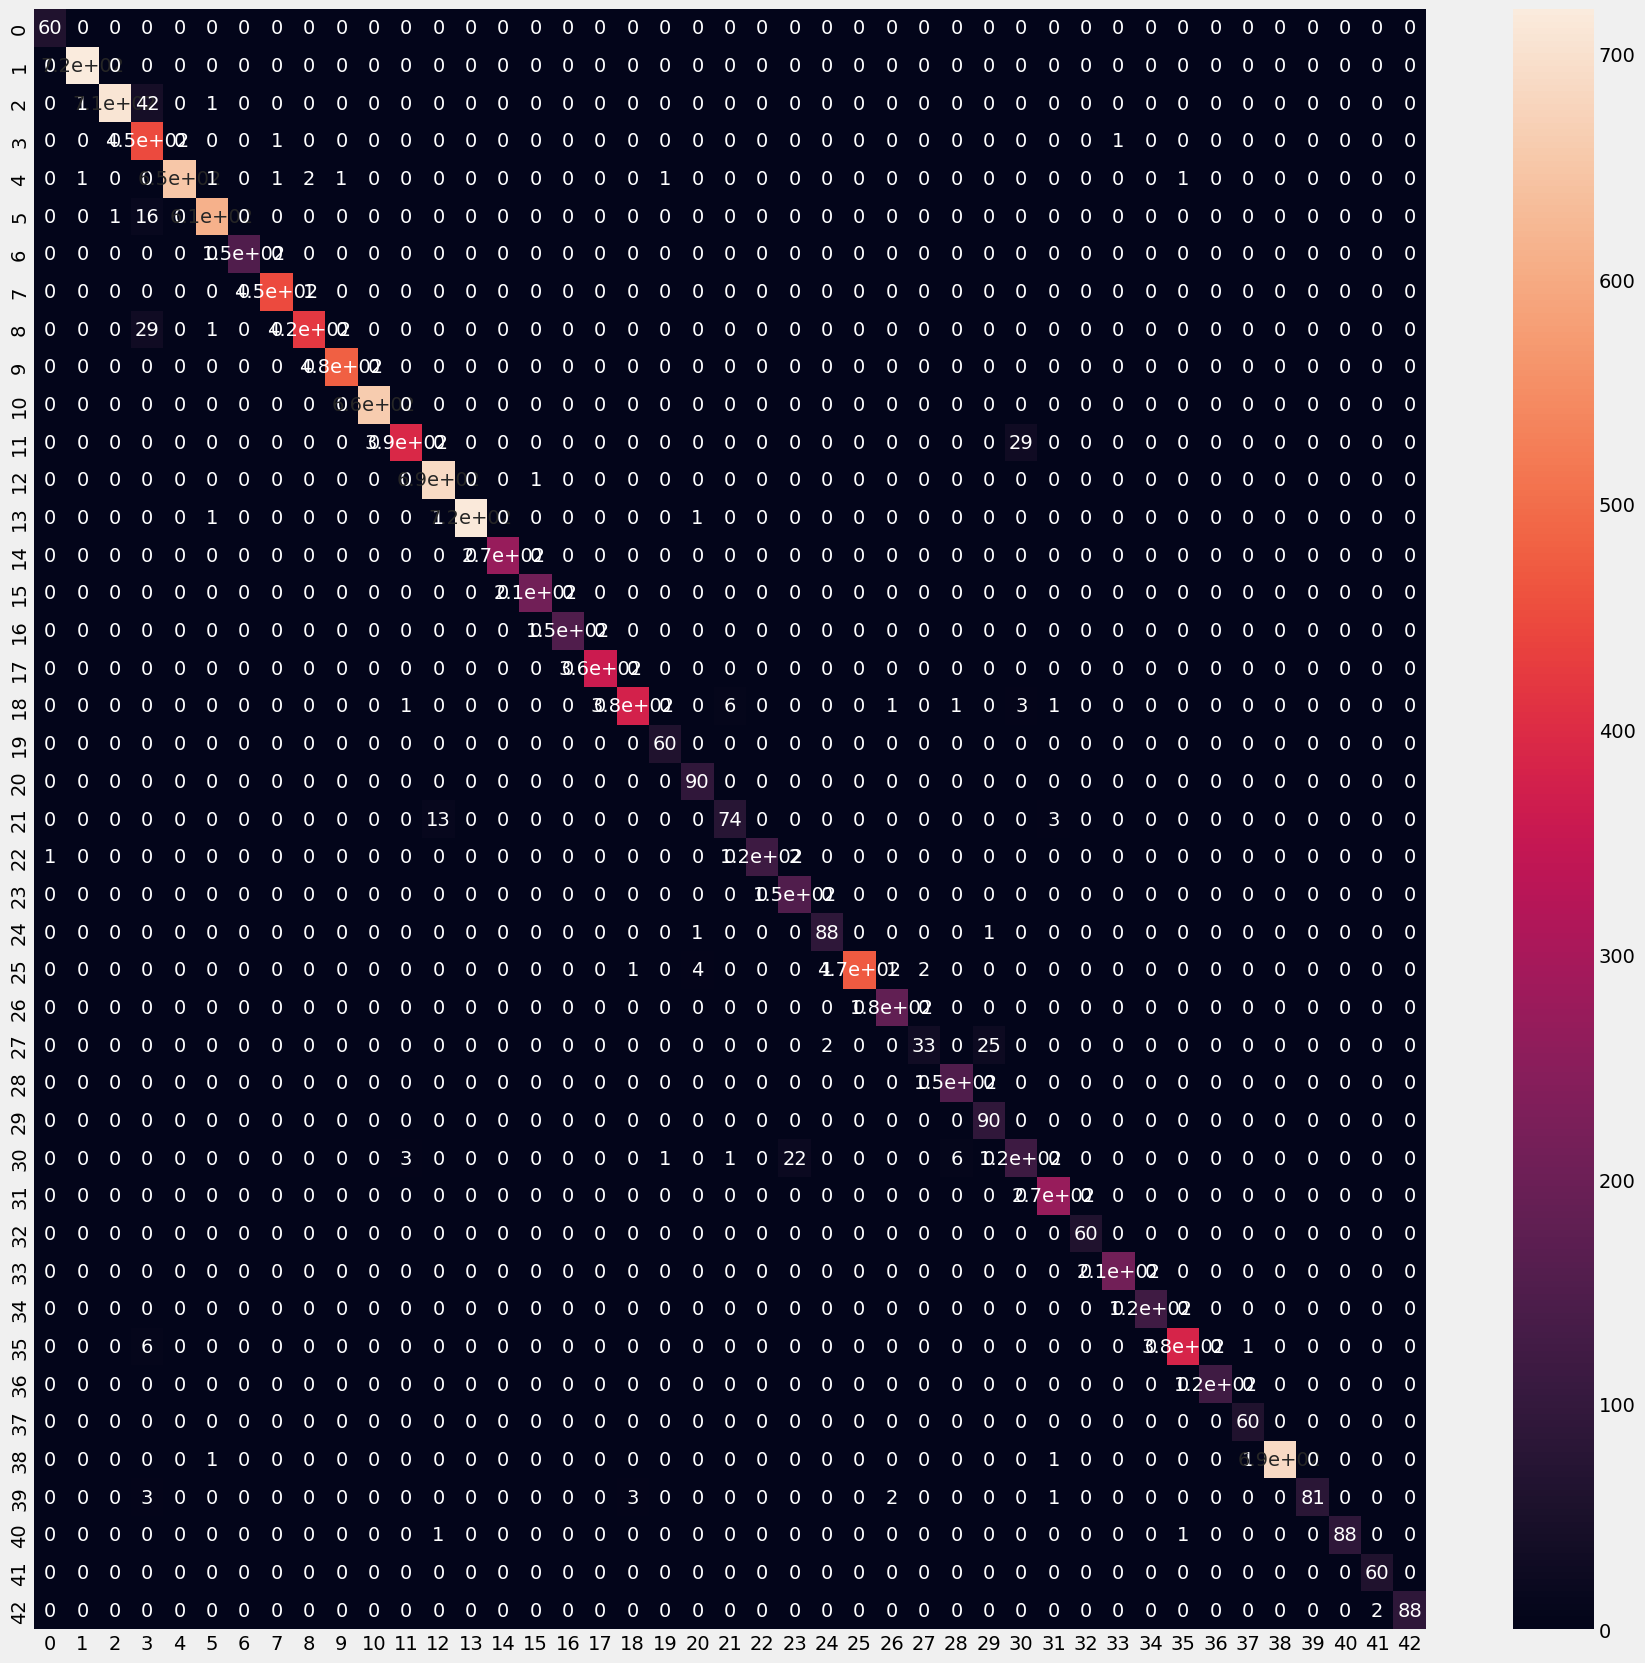

In [54]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification Report

In [55]:
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      1.00      1.00       720
           2       1.00      0.94      0.97       750
           3       0.82      1.00      0.90       450
           4       1.00      0.99      0.99       660
           5       0.99      0.97      0.98       630
           6       1.00      1.00      1.00       150
           7       1.00      1.00      1.00       450
           8       0.99      0.93      0.96       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.93      0.96       420
          12       0.98      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Prediction on Test Data

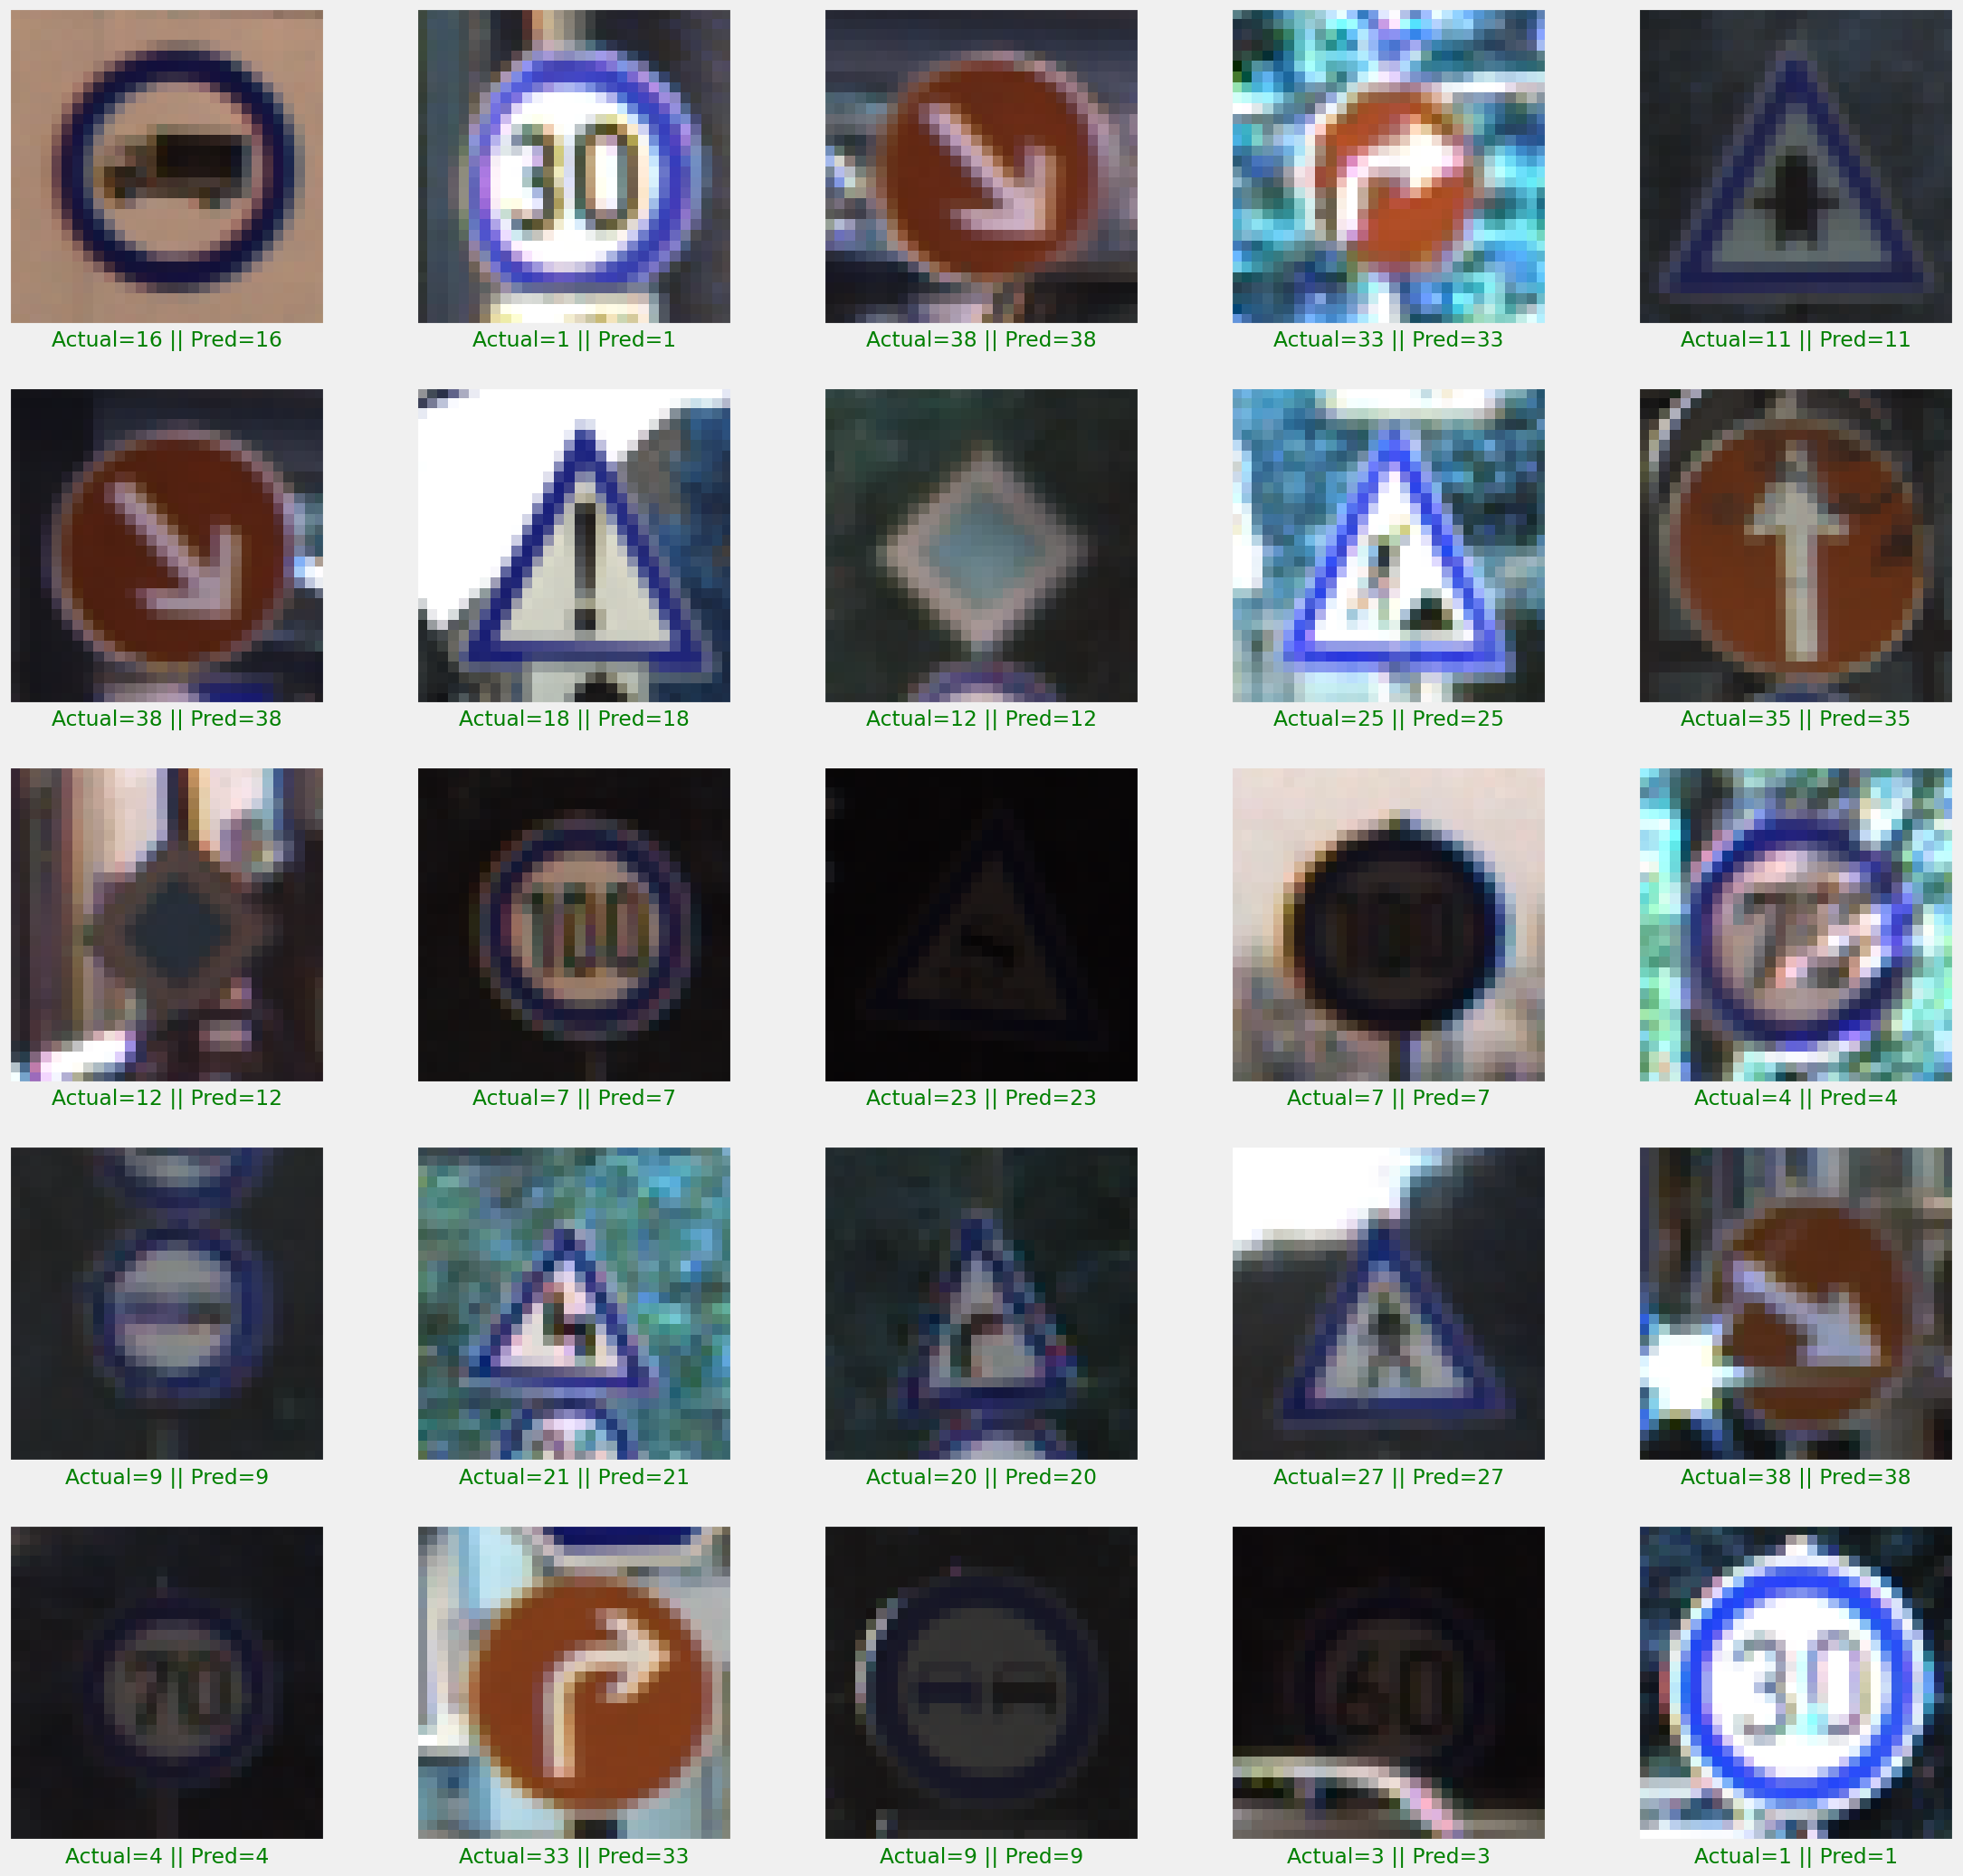

In [57]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [59]:
ls

meta/  Meta.csv  model.keras       test/  Test.csv  Train/
Meta/  model.h5  model.weights.h5  Test/  train/    Train.csv
